# 2022-09-23 Transient

## Last time

* Blasius working session
* Intro to transient problems

## Today
* Stability diagrams
* Energy dissipation
* Exploring the $\theta$ method
* PDE at ODE

In [32]:
using Plots
default(linewidth=3)
using LinearAlgebra
using SparseArrays

# Ordinary Differential Equations

Given initial condition $u_0 = u(t=0)$, find $u(t)$ for $t > 0$ that satisfies

$$ \dot u \equiv \frac{\partial u}{\partial t} = f(t, u) $$

| Application | $u$ | $f$ |
| --- | --- | --- |
| Orbital dynamics | position, momentum | conservation of momentum|
| Chemical reactions | concentration | conservation of atoms |
| Epidemiology | infected/recovered population | transmission and recovery |
| Heat transfer | temperature | conservation of energy |
| Seismology | displacement, momentum | conservative of momentum |

# Solving differential equations

## Linear equations

$$ \dot u = A(t) u + \text{source}(t)$$

* Autonomous if $A(t) = A$ and source independent of $t$

* Suppose $u$ and $a = A$ are scalars: $u(t) = e^{at} u_0$

## Can do the same for systems

$$ y(t) = e^{A t} y_0 $$

#### What does it mean to exponentiate a matrix?

Taylor series!

$$ e^A = 1 + A + \frac{A^2}{2} + \frac{A^3}{3!} + \dotsb $$
and there are many [practical ways to compute it](https://doi.org/10.1137/S00361445024180).

#### Question
Suppose that the diagonalization $A = X \Lambda X^{-1}$ exists and derive a finite expression for the matrix exponential using the scalar `exp` function.

# Forward Euler method

In [2]:
function ode_euler(f, u0; tfinal=10., h=0.1)
    u = copy(u0)
    t = 0.
    thist = [t]
    uhist = [u0]
    while t < tfinal
        tnext = min(t+h, tfinal)
        h = tnext - t
        u += h * f(t, u)
        t = tnext
        push!(thist, t)
        push!(uhist, u)
    end
    thist, hcat(uhist...)
end

ode_euler (generic function with 1 method)

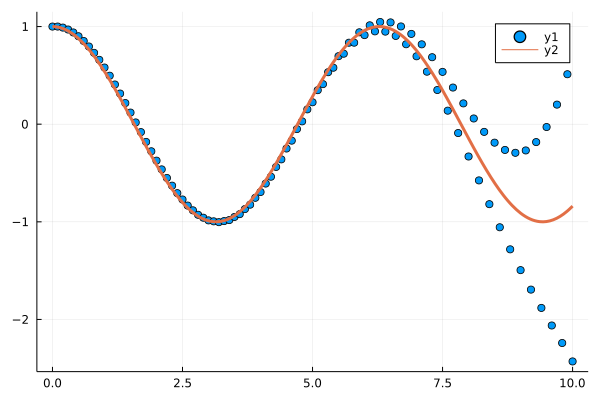

In [56]:
f1(t, u; k=21) = -k * (u .- cos(t))

thist, uhist = ode_euler(f1, [1.], tfinal=10, h=.1)
scatter(thist, uhist[1,:])
plot!(cos)

# Forward Euler on a linear system

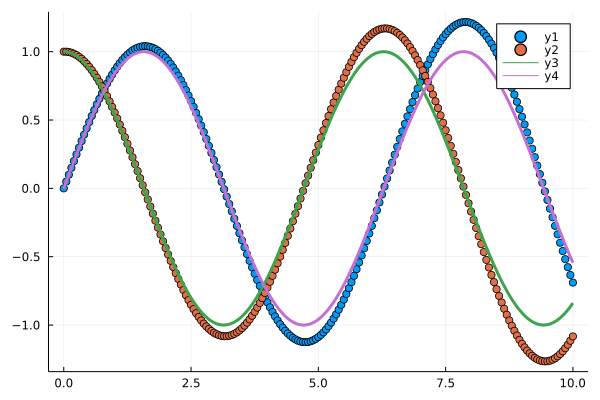

In [64]:
f2(t, u) = [0 1; -1 0] * u

thist, uhist = ode_euler(f2, [0, 1.], h=.05, tfinal=10)
scatter(thist, uhist')
plot!([cos, sin])

In [5]:
eigen([0 1; -1 0])

Eigen{ComplexF64, ComplexF64, Matrix{ComplexF64}, Vector{ComplexF64}}
values:
2-element Vector{ComplexF64}:
 0.0 - 1.0im
 0.0 + 1.0im
vectors:
2×2 Matrix{ComplexF64}:
 0.707107-0.0im       0.707107+0.0im
      0.0-0.707107im       0.0+0.707107im

### Linear Stability Analysis

Why did Euler converge on the first problem (with sufficiently small steps) while always diverging on the second problem?

We can understand the convergence of methods by analyzing the test problem
$$ \dot u = \lambda u $$
for different values of $\lambda$ in the complex plane.
One step of the Euler method with step size $h$ maps
$$ u \to u + h \lambda u = \underbrace{(1 + h \lambda)}_{R(h \lambda)} u $$
where we have introduced the complex-valued function $R(z)$.

* When does this map cause solutions to "blow up" and when is it stable?

# Stability diagrams (a property of methods)

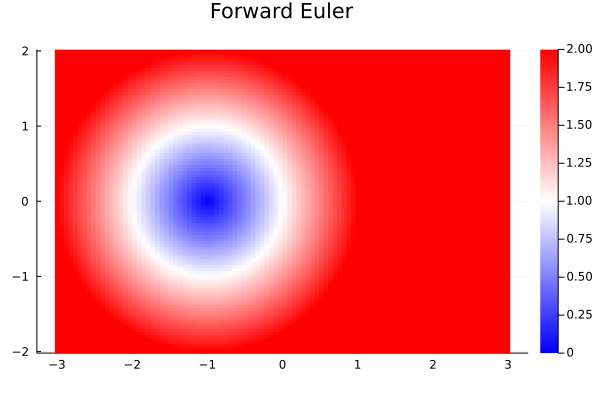

In [6]:
function plot_stability(Rz, title; xlims=(-3, 3), ylims=(-2, 2))
    x = LinRange(xlims[1], xlims[2], 100)
    y = LinRange(ylims[1], ylims[2], 100)
    heatmap(x, y, (x, y) -> abs(Rz(x + 1im*y)), c=:bwr, clims=(0, 2), aspect_ratio=:equal, title=title)
end
plot_stability(z -> 1 + z, "Forward Euler")

# Implicit methods

Recall that forward Euler is the step
$$ \tilde u(h) = u(0) + h f(0, u(0)) . $$
This can be evaluated **explicitly**; all the terms on the right hand side are known so the approximation $\tilde u(h)$ is computed merely by evaluating the right hand side.
Let's consider an alternative, **backward Euler** (or "implicit Euler"),
$$ \tilde u(h) = u(0) + h f(h, \tilde u(h)) . $$
This is a (generally) nonlinear equation for $\tilde u(h)$.
For the test equation $\dot u = \lambda u$, the backward Euler method is
$$ \tilde u(h) = u(0) + h \lambda \tilde u(h) $$
or
$$ \tilde u(h) = \underbrace{\frac{1}{1 - h \lambda}}_{R(h\lambda)} u(0) . $$

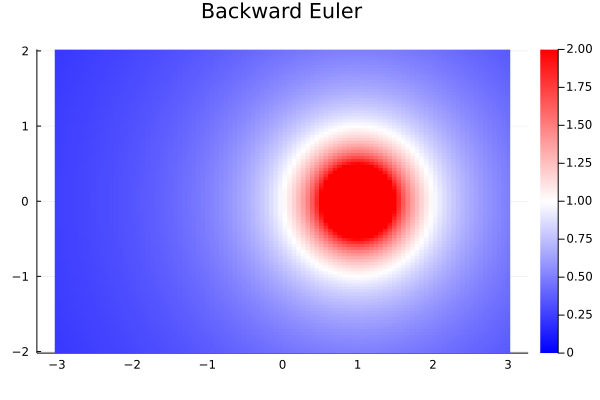

In [7]:
plot_stability(z -> 1 / (1 - z), "Backward Euler")

# Advection with centered stencil

In [80]:
function advect_center(t, u)
    n = length(u)
    dx = 2 / n
    uwrap = [u[end], u..., u[1]]
    f = zero(u)
    for i in 1:n
        f[i] = -(uwrap[i+2] - uwrap[i]) / (2*dx)
    end
    f
end

x = LinRange(-1, 1, 51)[1:end-1]
u0 = exp.(-9 * x .^ 2)
thist, uhist = ode_euler(advect_center, u0, h=.02, tfinal=1);

nsteps = 51


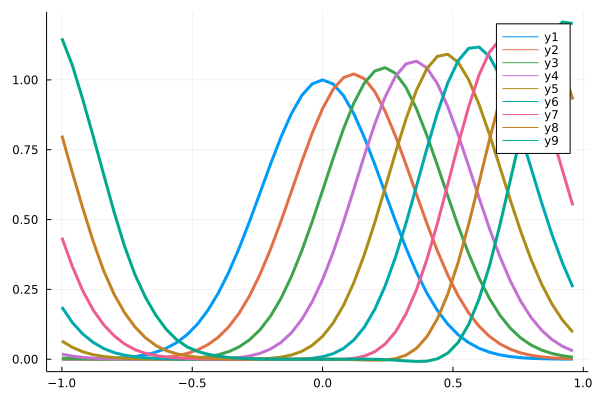

In [81]:
nsteps = size(uhist, 2)
@show nsteps
plot(x, uhist[:, 1:(nsteps÷8):end])

# Advection with upwind stencil

In [88]:
function advect_upwind(t, u)
    n = length(u)
    dx = 2 / n
    uwrap = [u[end], u..., u[1]]
    f = zero(u)
    for i in 1:n
        f[i] = -(uwrap[i+1] - uwrap[i]) / dx
    end
    f
end

x = LinRange(-1, 1, 51)[1:end-1]
u0 = exp.(-9 * x .^ 2)
@time thist, uhist = ode_euler(advect_upwind, u0, h=.04, tfinal=1);

  0.028710 seconds (62.33 k allocations: 3.267 MiB, 99.38% compilation time: 100% of which was recompilation)


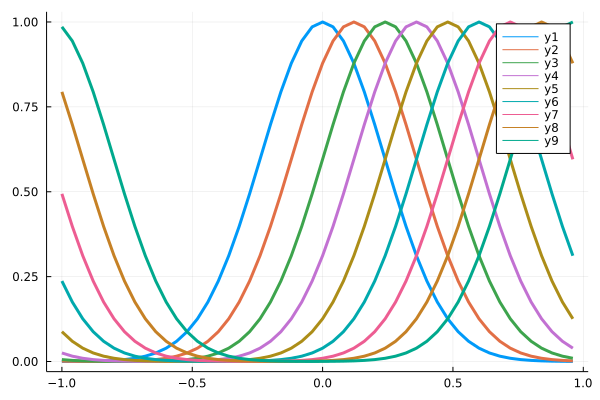

In [89]:
nsteps = size(uhist, 2)
plot(x, uhist[:, 1:(nsteps÷8):end])

# Centered advection with Runge-Kutta

In [92]:
function ode_rk4(f, u0; tfinal=10., h=0.4)
    u = copy(u0)
    t = 0.
    thist = [t]
    uhist = [u0]
    while t < tfinal
        tnext = min(t+h, tfinal)
        h = tnext - t
        ydot1 = f(t, u)
        ydot2 = f(t+h/2, u + h/2*ydot1)
        ydot3 = f(t+h/2, u + h/2*ydot2)
        ydot4 = f(t+h, u + h*ydot3)
        u += h/6 * (ydot1 + 2*ydot2 + 2*ydot3 + ydot4)
        t = tnext
        push!(thist, t)
        push!(uhist, u)
    end
    thist, hcat(uhist...)
end

ode_rk4 (generic function with 1 method)

  0.001142 seconds (23.52 k allocations: 1.274 MiB)


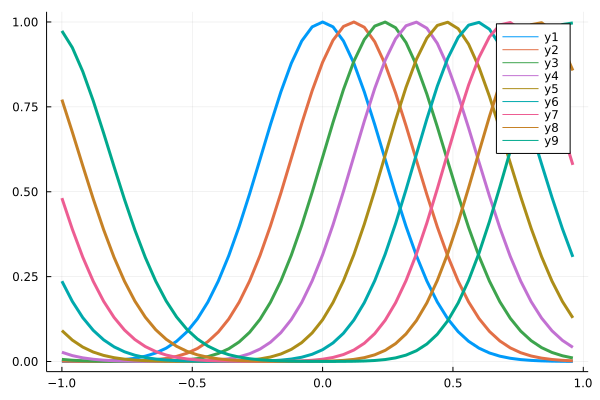

In [101]:
x = LinRange(-1, 1, 51)[1:end-1]
u0 = exp.(-9 * x .^ 2)
@time thist, uhist = ode_rk4(advect_center, u0, h=.01, tfinal=1);
nsteps = size(uhist, 2)
plot(x, uhist[:, 1:(nsteps÷8):end])

# Midpoint/trapezoid and $\theta$ methods

Forward and backward Euler are bookends of the family known as $\theta$ methods.

$$ \tilde u(h) = u(0) + h f\Big(\theta h, \theta\tilde u(h) + (1-\theta)u(0) \Big) $$

which, for linear problems, is solved as

$$ (I - h \theta A) u(h) = \Big(I + h (1-\theta) A \Big) u(0) . $$

$\theta=0$ is explicit Euler, $\theta=1$ is implicit Euler, and $\theta=1/2$ are the midpoint or trapezoid rules (equivalent for linear problems).
The stability function is
$$ R(z) = \frac{1 + (1-\theta)z}{1 - \theta z}. $$

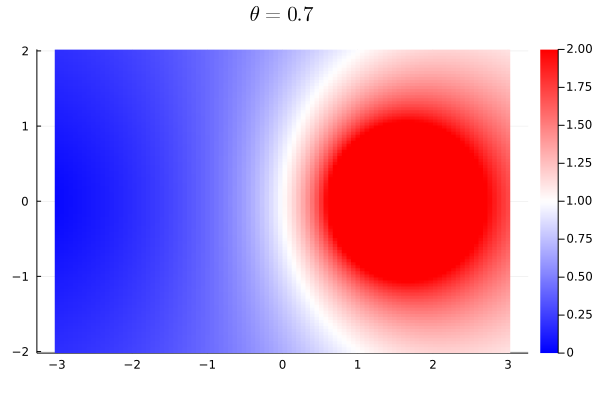

In [106]:
Rz_theta(z, theta) = (1 + (1-theta)*z) / (1 - theta*z)
theta=0.7
plot_stability(z -> Rz_theta(z, theta), "\$\\theta=$theta\$")

# A $\theta$ solver

In [107]:
function ode_theta_linear(A, u0; forcing=zero, tfinal=1, h=0.1, theta=.5)
    u = copy(u0)
    t = 0.
    thist = [t]
    uhist = [u0]
    while t < tfinal
        tnext = min(t+h, tfinal)
        h = tnext - t
        rhs = (I + h*(1-theta)*A) * u .+ h*forcing(t+h*theta)
        u = (I - h*theta*A) \ rhs
        t = tnext
        push!(thist, t)
        push!(uhist, u)
    end
    thist, hcat(uhist...)
end

ode_theta_linear (generic function with 1 method)

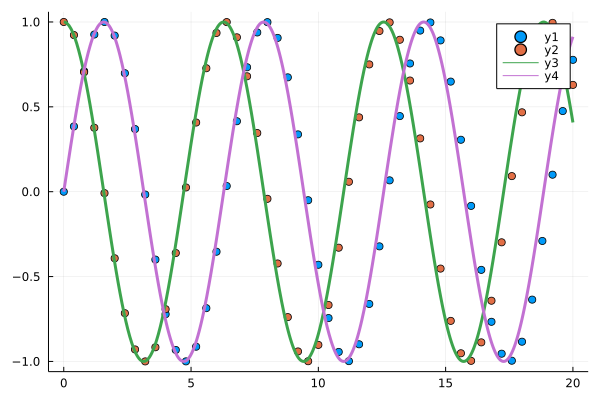

In [115]:
# Test on oscillator
A = [0 1; -1 0]
thist, uhist = ode_theta_linear(A, [0., 1], h=.4, theta=.5, tfinal=20)
scatter(thist, uhist')
plot!([cos, sin])

# Stiff decay to cosine

$$\dot u = -k(u - \cos t) = -k u + k \cos t$$

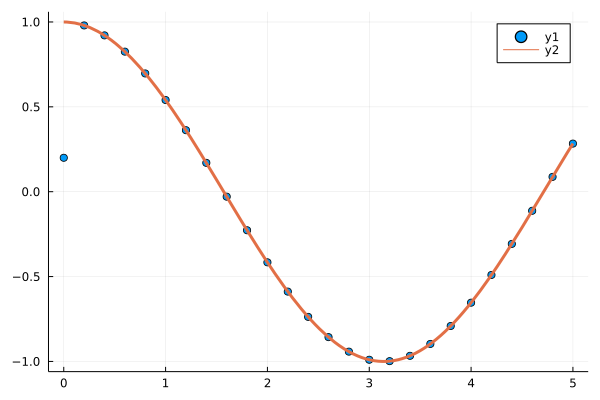

In [137]:
k = 10000
thist, uhist = ode_theta_linear(-k, [.2], forcing=t -> k*cos(t), tfinal=5, h=.2, theta=1)
scatter(thist, uhist[1,:])
plot!(cos)

# Advection as linear ODE

In [142]:
function advect_matrix(n; upwind=false)
    dx = 2 / n
    rows = [1]
    cols = [1]
    vals = [0.]
    wrap(j) = (j + n - 1) % n + 1
    for i in 1:n
        append!(rows, [i, i])
        if upwind
            append!(cols, wrap.([i-1, i]))
            append!(vals, [1., -1] ./ dx)
        else
            append!(cols, wrap.([i-1, i+1]))
            append!(vals, [1., -1] ./ 2dx)
        end
    end
    sparse(rows, cols, vals)
end
eigvals(Matrix(advect_matrix(10)))

10-element Vector{ComplexF64}:
                    0.0 - 2.938926261462368im
                    0.0 - 2.9389262614623664im
                    0.0 - 1.2560848302247556e-16im
                    0.0 + 1.2560848302247556e-16im
                    0.0 + 2.9389262614623664im
                    0.0 + 2.938926261462368im
   4.81482486096809e-34 - 4.755282581475769im
   4.81482486096809e-34 + 4.755282581475769im
 3.0814879110195774e-33 - 4.7552825814757655im
 3.0814879110195774e-33 + 4.7552825814757655im

  0.001073 seconds (2.39 k allocations: 2.140 MiB)


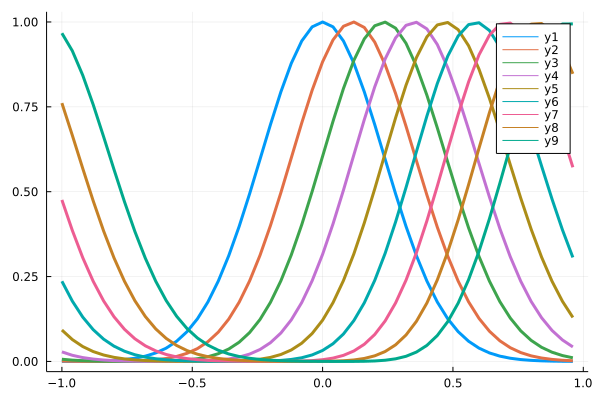

In [153]:
n = 50
A = advect_matrix(n, upwind=false)
x = LinRange(-1, 1, n+1)[1:end-1]
u0 = exp.(-9 * x .^ 2)
@time thist, uhist = ode_theta_linear(A, u0, h=.04, theta=0.5, tfinal=1.);
nsteps = size(uhist, 2)
plot(x, uhist[:, 1:(nsteps÷8):end])

# Heat equation as linear ODE

* How do different $\theta \in [0, 1]$ compare in terms of stability?
* Are there artifacts even when the solution is stable?

In [20]:
function heat_matrix(n)
    dx = 2 / n
    rows = [1]
    cols = [1]
    vals = [0.]
    wrap(j) = (j + n - 1) % n + 1
    for i in 1:n
        append!(rows, [i, i, i])
        append!(cols, wrap.([i-1, i, i+1]))
        append!(vals, [1, -2, 1] ./ dx^2)
    end
    sparse(rows, cols, vals)
end
heat_matrix(5)

5×5 SparseMatrixCSC{Float64, Int64} with 15 stored entries:
 -12.5     6.25     ⋅       ⋅      6.25
   6.25  -12.5     6.25     ⋅       ⋅ 
    ⋅      6.25  -12.5     6.25     ⋅ 
    ⋅       ⋅      6.25  -12.5     6.25
   6.25     ⋅       ⋅      6.25  -12.5

  0.097316 seconds (115.83 k allocations: 6.464 MiB, 99.09% compilation time)


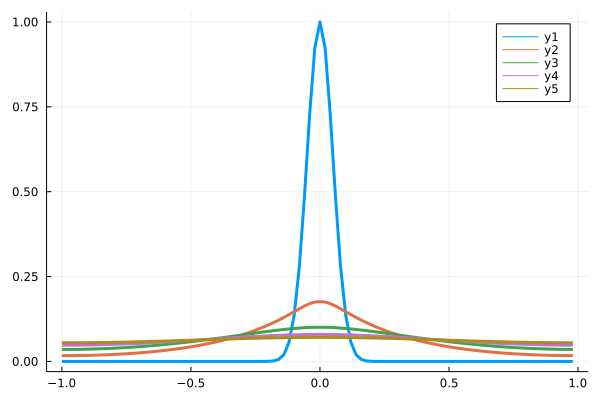

In [21]:
n = 100
A = heat_matrix(n)
x = LinRange(-1, 1, n+1)[1:end-1]
u0 = exp.(-200 * x .^ 2)
@time thist, uhist = ode_theta_linear(A, u0, h=.1, theta=1, tfinal=1);
nsteps = size(uhist, 2)
plot(x, uhist[:, 1:5])